In [1]:
import pandas as pd

In [2]:
cd C:/Users/santh/OneDrive/Desktop/Course Materials/Data Mining/Final Project/Git-Code/Dock_Watch/01. Data Collection & Storage/03. Collected Datasets/02. Preprocessed Data/

C:\Users\santh\OneDrive\Desktop\Course Materials\Data Mining\Final Project\Git-Code\Dock_Watch\01. Data Collection & Storage\03. Collected Datasets\02. Preprocessed Data


In [135]:
merged_df = pd.read_csv('merged_data_final.csv')
merged_df.shape

(494763, 44)

In [136]:
# merged_df = merged_df.loc[merged_df['station_capacity'] ==merged_df['docks_available'] ]

### Selecting Folsom & Colorado

In [139]:
df = merged_df[['cu_class_status', 'day_of_week_rnd',  'hour_rnd','station_name','docks_available', 'bikes_available', 'station_capacity','new_docks_available', 'new_bikes_available','bike_wait_time','dock_wait_time','temperature_2m', 'precipitation_probability', 'snow_depth', 'visibility']] 

# selected_stations = [
#     'Folsom & Colorado', '13th & College', 'Broadway & Euclid', 'CU Recreation Center',
#     '18th & Colorado', 'Farrand Field', 'Center for Community @ Regent Drive',
#     'Broadway & Baseline', 'Timber Ridge @ Adams Circle', 'Williams Village'
# ]

selected_stations = [
    'Folsom & Colorado'
]

# Assuming df is your DataFrame
df = df[df['station_name'].isin(selected_stations)]


In [62]:
df.dtypes

cu_class_status               object
day_of_week_rnd               object
hour_rnd                       int64
station_name                  object
docks_available                int64
bikes_available                int64
station_capacity               int64
new_docks_available            int64
new_bikes_available            int64
bike_wait_time               float64
dock_wait_time               float64
temperature_2m               float64
precipitation_probability    float64
snow_depth                   float64
visibility                   float64
dtype: object

### Label Encoding

In [142]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['cu_class_status', 'day_of_week_rnd', 'station_name']

label_encoder = LabelEncoder()

# Apply label encoding to each column
for col in columns_to_encode:
    df[col + '_encoded'] = label_encoder.fit_transform(df[col])

# Drop the original categorical columns if needed
df.drop(columns=columns_to_encode, inplace=True)

## Feature vs Target Visualization

Since there are multiple regression models and we have narrow down to understand the data linearity. 

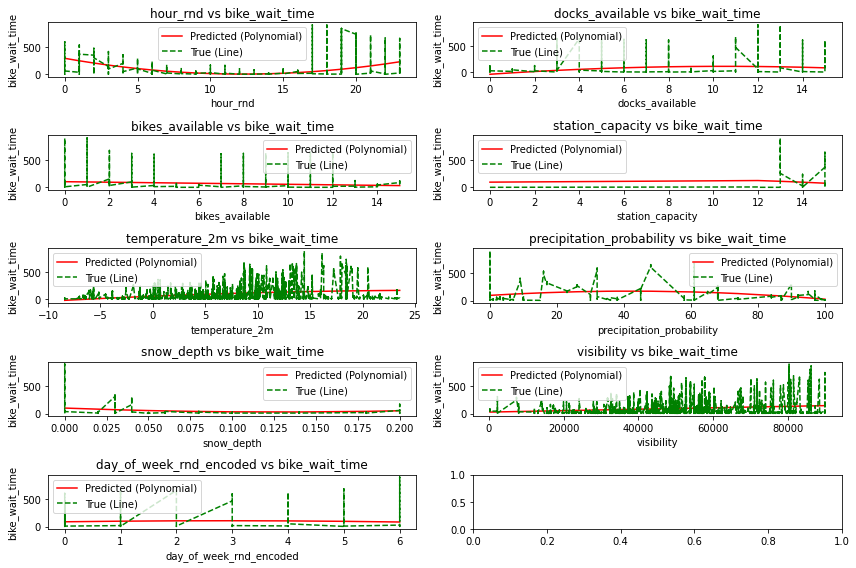

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
df.reset_index(drop=True, inplace=True)
# Assuming df is your DataFrame containing the specified columns
input_cols = ['hour_rnd', 'docks_available', 'bikes_available', 'station_capacity',
        'temperature_2m', 'precipitation_probability',
       'snow_depth', 'visibility',
       'day_of_week_rnd_encoded']
output_col = 'bike_wait_time'
num_cols = len(input_cols)


num_rows = math.ceil(num_cols / 2)  # Adjust rows based on the number of columns for layout

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 8))  # Create a layout of subplots

for i, col in enumerate(input_cols):
    row = i // 2
    col_num = i % 2
    ax = axes[row, col_num] if num_rows > 1 else axes[col_num]
    
    # Scatter plot for actual values
#     ax.scatter(df[col], df[output_col], label='Actual')
    
    # Fit polynomial regression line
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(df[[col]])
    model = LinearRegression().fit(X_poly, df[output_col])
    y_pred = model.predict(X_poly)
    
    # Sort the values for smooth curve plotting
    sort_axis = np.argsort(df[col])
    
    # Plotting the predicted values
    ax.plot(df[col][sort_axis], y_pred[sort_axis], color='red', label='Predicted (Polynomial)')
    
    # Plotting the line for true values
    ax.plot(df[col][sort_axis], df[output_col][sort_axis], color='green', linestyle='--', label='True (Line)')
    
    ax.set_title(f'{col} vs {output_col}')
    ax.set_xlabel(col)
    ax.set_ylabel(output_col)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Model - XGBRegressor

In [146]:
X_bike = df[['hour_rnd', 'docks_available', 'bikes_available', 'station_capacity',
 'temperature_2m', 'precipitation_probability',
       'snow_depth', 'visibility', 'cu_class_status_encoded',
       'day_of_week_rnd_encoded', 'station_name_encoded']]
Y_bike = df[['bike_wait_time']]
X_dock = df[['hour_rnd', 'docks_available', 'bikes_available', 'station_capacity',
     'temperature_2m', 'precipitation_probability',
       'snow_depth', 'visibility', 'cu_class_status_encoded',
       'day_of_week_rnd_encoded', 'station_name_encoded']]
Y_dock = df[['dock_wait_time']]

Mean Squared Error (MSE): 103.57132978427703
Root Mean Squared Error (RMSE): 10.177000038531837
Mean Absolute Error (MAE): 8.003966333988672
R-squared: 0.9957908552211195


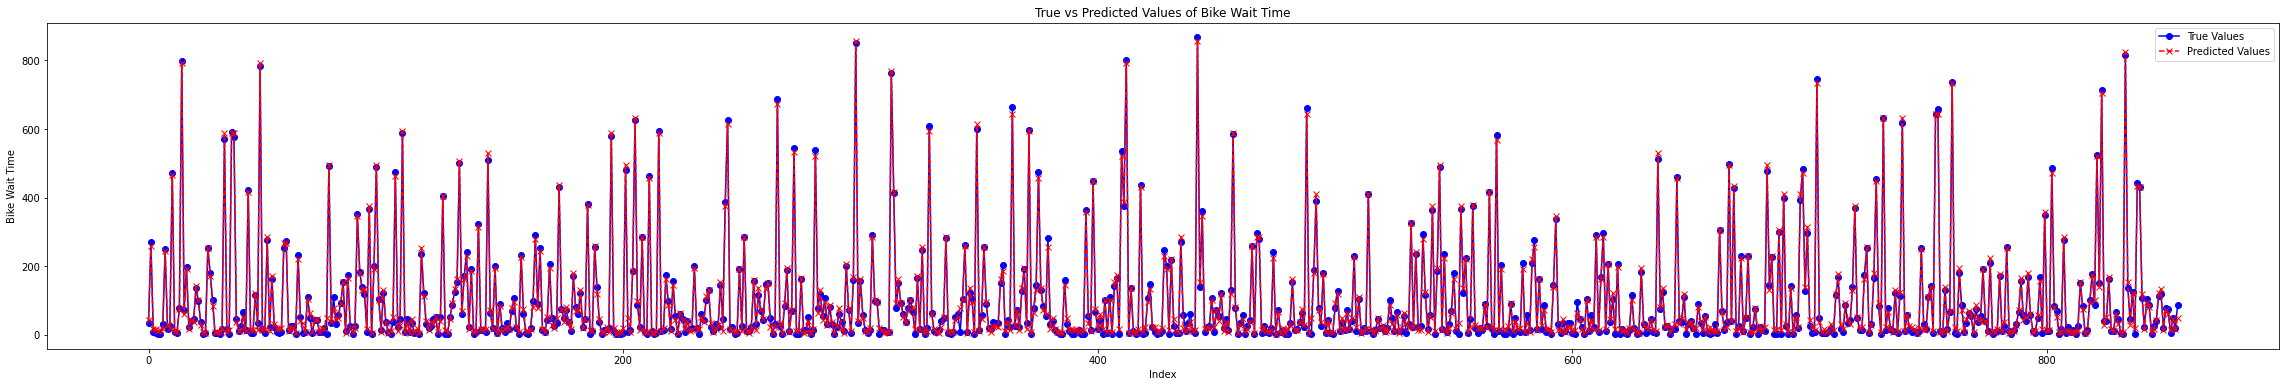

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import xgboost as xgb

# Assuming X_bike contains input features and Y_bike contains output variable
X_train, X_test, y_train, y_test = train_test_split(X_bike, Y_bike, test_size=0.2, random_state=42)

# # # Initialize XGBoost regressor
# xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
#                           max_depth=5, alpha=10, n_estimators=10)

# best hyper parameters
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.2,
                          max_depth=7, n_estimators=150, alpha=10)
# Fit the model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = (mse)**0.5  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test)), y_test, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')

plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time')
plt.legend()
plt.show()

### Prediction vs True data

In [129]:
import pandas as pd

# Convert y_test and y_pred DataFrame columns to lists
y_test_list = y_test['bike_wait_time'].tolist()  # Replace 'your_column_name' with the actual column name
y_pred_list = y_pred.tolist()

# Creating a DataFrame to display y_pred and y_test
results_df = pd.DataFrame({'True_Values': y_test_list, 'Predicted_Values': y_pred_list})

# Displaying the DataFrame
print(results_df)

     True_Values  Predicted_Values
0           33.0         44.567402
1          270.0        259.870911
2            9.0         15.564244
3            6.0         17.138262
4            3.0         10.229012
..           ...               ...
851         75.0         59.451157
852          6.0         13.890688
853         48.0         47.051151
854         21.0         16.554155
855         87.0         49.044563

[856 rows x 2 columns]


### Feature Importance

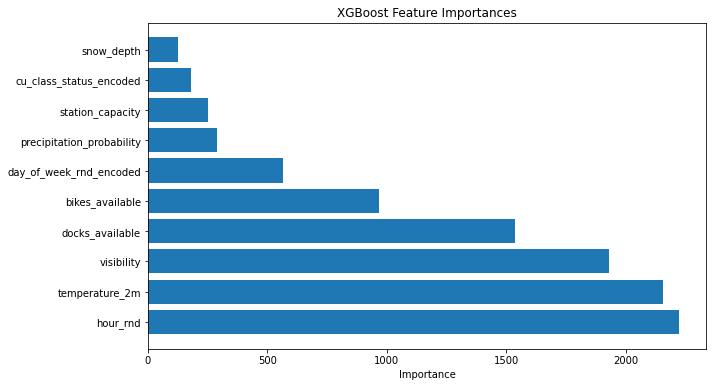

In [73]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_model is your trained XGBoost model
# You can access feature importances directly from the model
feature_importances = xg_reg.get_booster().get_score(importance_type='weight')

# Sort the feature importances
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(*zip(*sorted_feature_importances))
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.show()



### Hyper Parameter Tuning

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Mean Squared Error (MSE): 495.51041474431787
Root Mean Squared Error (RMSE): 22.260063224176115
Mean Absolute Error (MAE): 10.355752582105296
R-squared: 0.9780532305476894


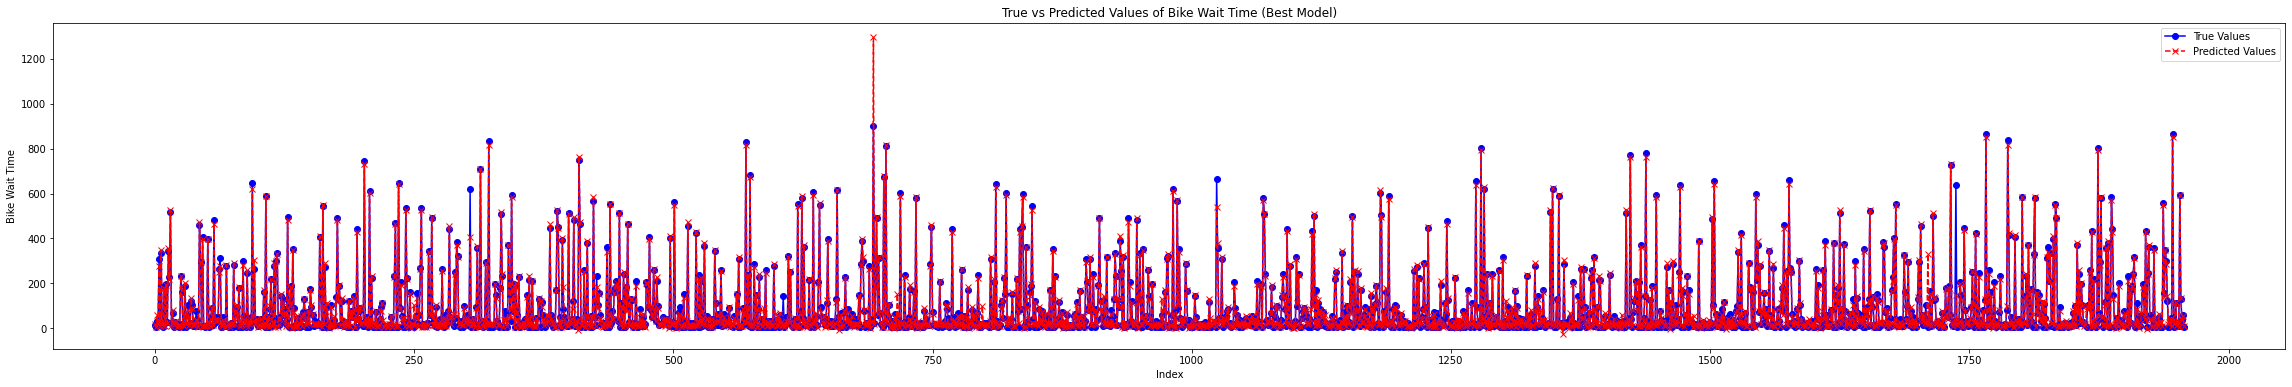

In [70]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their values to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'colsample_bytree': [0.3, 0.5, 0.7]  # Fraction of features used per tree
}

# Initialize XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', alpha=10, random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_xg_reg = grid_search.best_estimator_

# Predict using the best model
y_pred = best_xg_reg.predict(X_test)

# Evaluation metrics with the best model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculating RMSE from MSE

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

# Plot true values and predicted values in a line chart with the best model
plt.figure(figsize=(40, 6))
plt.plot(np.arange(len(y_test)), y_test, label='True Values', marker='o', linestyle='-', color='blue')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted Values', marker='x', linestyle='--', color='red')

plt.xlabel('Index')
plt.ylabel('Bike Wait Time')
plt.title('True vs Predicted Values of Bike Wait Time (Best Model)')
plt.legend()
plt.show()
